## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [32]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import scipy as sp
import sklearn as sk

import pickle
import joblib
import random

import scipy.stats as stats
from statsmodels.stats import proportion as proptests

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# load Machine Learning packages
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# load in the data
train_data = pd.read_csv('./training.csv', index_col='ID')

## Exploratory Data Analysis

In [4]:
print(train_data.head())
print('\n')
print(len(train_data))

   Promotion  purchase  V1         V2        V3  V4  V5  V6  V7
ID                                                             
1         No         0   2  30.443518 -1.165083   1   1   3   2
3         No         0   3  32.159350 -0.645617   2   3   2   2
4         No         0   2  30.431659  0.133583   1   1   4   2
5         No         0   0  26.588914 -0.212728   2   1   4   2
8        Yes         0   3  28.044331 -0.385883   1   1   2   2


84534


In [5]:
# check for null values
train_data.isna().sum()

Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [6]:
# check number of distinct elements
train_data.nunique()

Promotion        2
purchase         2
V1               4
V2           84518
V3              40
V4               2
V5               4
V6               4
V7               2
dtype: int64

<br>The distribution of data is balanced between the <B>control</B> (non-promotional) and <B>treatment</B> (promotion) groups.
<br>The distribution of data is severly <i>imbalanced</i> between the <B>purchase</B> and <B>non-purchase</B> groups.

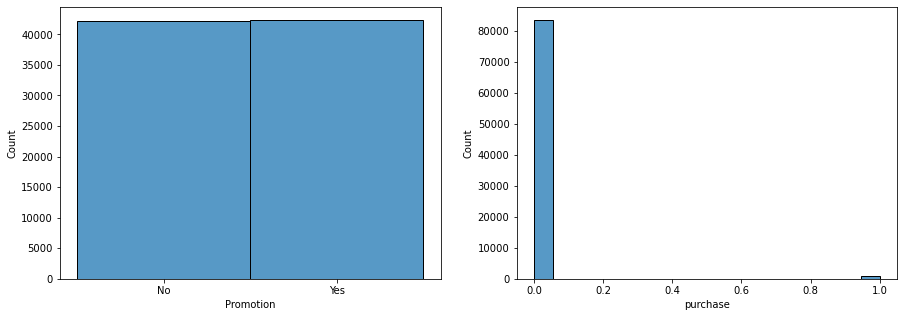

In [7]:
fig, axs = plt.subplots(1, 2,figsize=(15, 5), sharey=False)
sns.histplot(data=train_data, x='Promotion', ax=axs[0]);
sns.histplot(data=train_data, x='purchase', ax=axs[1]);

<br>The features have different ranges.
<br>Transformation and scaling the features is necessary prior to applying the Machine Learning algorithms and classification.

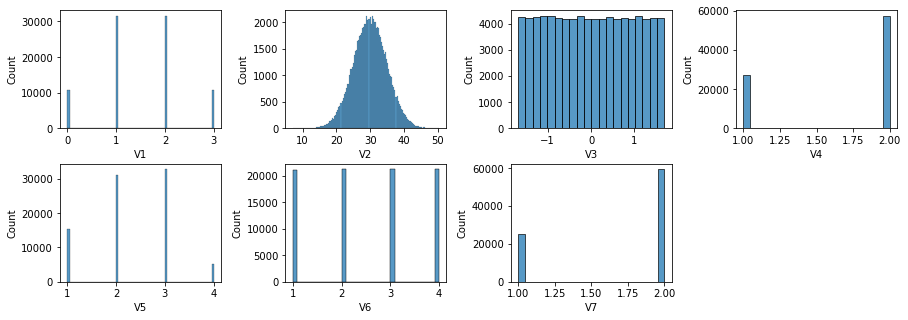

In [8]:
fig, axs = plt.subplots(2, 4,figsize=(15, 5), sharey=False)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.3)
sns.histplot(data=train_data, x='V1', ax=axs[0,0]);
sns.histplot(data=train_data, x='V2', ax=axs[0,1]);
sns.histplot(data=train_data, x='V3', bins=20, ax=axs[0,2]);
sns.histplot(data=train_data, x='V4', ax=axs[0,3]);
sns.histplot(data=train_data, x='V5', ax=axs[1,0]);
sns.histplot(data=train_data, x='V6', ax=axs[1,1]);
sns.histplot(data=train_data, x='V7', ax=axs[1,2]);
axs[1, 3].axis('off');

## A two-stage classification is implemented 

## Stage-1

### The control group is used and the model is trained to classify purchase data

The objective of this step is to <b>classify</b> customers who would purchase the product regardless of recieving the promotion (<i>default purcheser</i>).

In [9]:
df_ctrl = train_data.query('Promotion=="No"')

In [10]:
X = df_ctrl[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y = df_ctrl['purchase']

In [11]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# define pipeline steps
pipeline_steps = [('sampler', SMOTE(random_state=42)), # to perform over-sampling for the imbalanced dataset
                  ('scaler', MinMaxScaler()), # to scale and translate each feature betwwen 0 and 1
                  ('pca', PCA()),
                  ('clf', KNeighborsClassifier(weights='distance'))
                 ]

In [13]:
pipeline = imbpipeline(pipeline_steps)

In [14]:
param_grid = {
    'sampler__k_neighbors': np.arange(1,6),
    'pca__n_components': np.arange(5,8),
    'clf__n_neighbors': np.arange(1,6),
}

In [15]:
model_1 = GridSearchCV(pipeline, param_grid, n_jobs=2)

In [16]:
model_1.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('sampler', SMOTE(random_state=42)),
                                       ('scaler', MinMaxScaler()),
                                       ('pca', PCA()),
                                       ('clf',
                                        KNeighborsClassifier(weights='distance'))]),
             n_jobs=2,
             param_grid={'clf__n_neighbors': array([1, 2, 3, 4, 5]),
                         'pca__n_components': array([5, 6, 7]),
                         'sampler__k_neighbors': array([1, 2, 3, 4, 5])})

In [17]:
print("Best parameter (CV score=%0.3f):" % model_1.best_score_)
print(model_1.best_params_)

Best parameter (CV score=0.972):
{'clf__n_neighbors': 1, 'pca__n_components': 7, 'sampler__k_neighbors': 1}


In [18]:
pickle.dump(model_1, open('clf_stage_1.pkl', 'wb'))

## Stage-2

### The treatment group is used; the second model is trained to classify customers that make a purchase with promotion

<br>1- Classifier-1 (trained in stage 1) is used to remove default purchasers from treatment group
<br>2- Train a second classifier, that classifies customers who make a purchase after reciving a promotion

In [34]:
df_exp = train_data.query('Promotion=="Yes"')

In [35]:
X_exp = df_exp[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]

In [36]:
y_pred_exp = model_1.predict(X_exp)

In [37]:
df_exp['default_purchase'] = y_pred_exp

In [23]:
df_exp = df_exp.drop(df_exp[df_exp.default_purchase==1].index) # drop default purchaser

In [24]:
model_2 = GridSearchCV(pipeline, param_grid, n_jobs=2)

In [25]:
X = df_exp[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y = df_exp['purchase']

In [26]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
model_2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('sampler', SMOTE(random_state=42)),
                                       ('scaler', MinMaxScaler()),
                                       ('pca', PCA()),
                                       ('clf',
                                        KNeighborsClassifier(weights='distance'))]),
             n_jobs=2,
             param_grid={'clf__n_neighbors': array([1, 2, 3, 4, 5]),
                         'pca__n_components': array([5, 6, 7]),
                         'sampler__k_neighbors': array([1, 2, 3, 4, 5])})

In [28]:
print("Best parameter (CV score=%0.3f):" % model_2.best_score_)
print(model_2.best_params_)

Best parameter (CV score=0.938):
{'clf__n_neighbors': 1, 'pca__n_components': 7, 'sampler__k_neighbors': 1}


In [29]:
pickle.dump(model_2, open('clf_stage_2.pkl', 'wb'))

## Using the trained models and validate the results using a new dataset

In [30]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	f3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    model_1 = joblib.load("clf_stage_1.pkl")
    model_2 = joblib.load("clf_stage_2.pkl")

    indeces = np.array(range(len(df)))

    clf_labels_1 = model_1.predict(df)
    ind_1 = indeces[clf_labels_1==0]

    fltrd_df_1 = df.iloc[ind_1]

    indeces = np.array(range(len(fltrd_df_1)))

    clf_labels_2 = model_2.predict(fltrd_df_1)
    ind_2 = indeces[clf_labels_2==1]

    fltrd_df_2 = fltrd_df_1.iloc[ind_2]

    promotion = pd.DataFrame(index=df.index, columns=['result'])
    promotion.result = 'No'
    promotion.loc[fltrd_df_2.index]='Yes'
    
    return promotion.result

In [31]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0219.

Your nir with this strategy is 69.85.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.02187883038946869, 69.85)